# VAR-Prophet

In [1]:
# VAR Model
from statsmodels.tsa.api import VAR

# Prophet model
from prophet import Prophet

from datetime import timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
df = pd.read_csv("../Data/KRS_cleaned_linear_interpolation.csv", index_col=['FLOW_DATE'], parse_dates=['FLOW_DATE'])
df = df.fillna(method='ffill')
df['MONTH_NO'] = df.index.month

In [3]:
dataset = df[['RES_LEVEL_FT', 'INFLOW_CUSECS', 'OUTFLOW_CUECS', 'WEEK_NO', 'MONTH_NO']].reset_index()
dataset.head(5)

,FLOW_DATE,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,WEEK_NO,MONTH_NO
0,2011-01-01,122.59,2029.0,2000.0,1.0,1
1,2011-01-02,122.68,3084.0,1490.0,1.0,1
2,2011-01-03,122.75,2776.0,1491.0,1.0,1
3,2011-01-04,122.79,2311.0,1491.0,1.0,1
4,2011-01-05,122.80,1847.0,1491.0,1.0,1


## Visualization

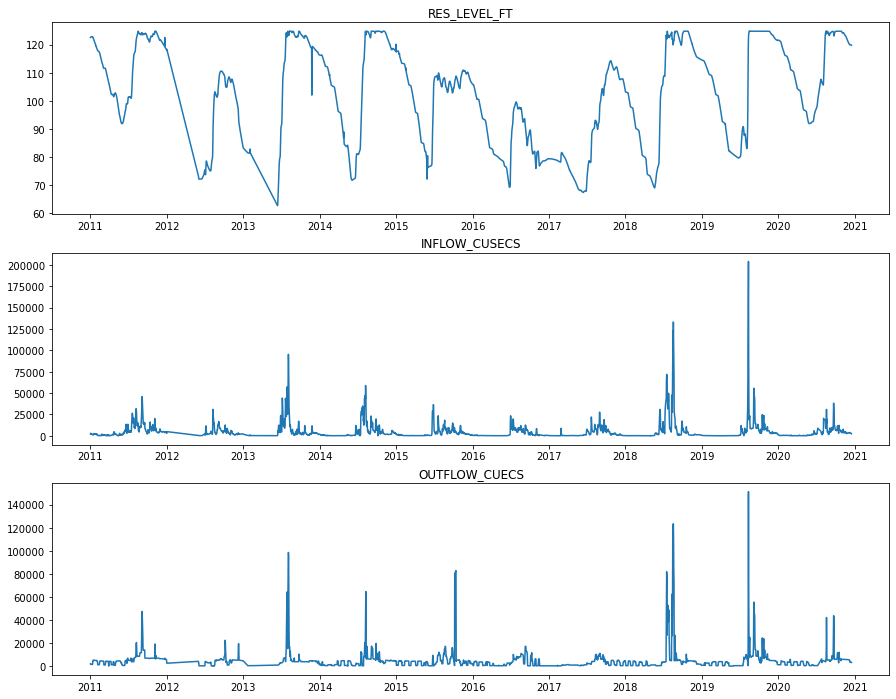

In [4]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 12))
for i, col in enumerate(dataset.iloc[0, 1:4].index):
    ax[i].plot(dataset.set_index('FLOW_DATE')[col])
    ax[i].set_title(col)
# df[['RES_LEVEL_FT', 'INFLOW_CUSECS', 'OUTFLOW_CUECS']].plot(ax=ax)

## Helper Functions

In [5]:
def data_subset(dataset:'pd.DataFrame',
                time_col:'str',
                dependent_variable:'str',
                internal_regressors:'list',
                train_start:'str',
                test_start:'str',
                test_end:'str',
                external_regressors:'list'=None)->('pd.DataFrame', 'pd.DataFrame'):
    """
        Funtion to subset timeseries into train and test set, dependent on the time constraints.
        
        Parameters:
            dataset (pd.DataFrame): 
                Input dataset
            time_col (str): 
                Name of the timeseries index column
            dependent_variable (str): 
                Name of the variable we are looking to forecast
            internal_regressors (list): 
                List of names of columns that will act as internal regressors. For VAR model, these are endogenous
                variables. For Prophet, they will be part of the regressors.
            train_start (str):
                Date from which to start the training set (helps in cross-validation)
            test_start (str):
                Date from which to start the test set (subset dataset)
            test_end (str):
                Date till which to make predictions (depends on the forecast horizon)
            external_regressors (list):
                List of names of columns that will act as external regressors. For VAR model, these will be exogenous
                variables. For Prophet, they will be same as internal regressors.
                None implies no external regressors.
                
        Returns:
            (pd.DataFrame): 
                Training Set
            (pd.DataFrame):
                Test Set
    """
    # Make a copy of dataset to prevent accidentally changing the original
    data_copy = dataset.copy()
    
    # Select the required variables
    if external_regressors is None:
        data_copy = data_copy.set_index(time_col).drop(columns = [column \
                                                                  for column in dataset.columns \
                                                                  if column not in internal_regressors + \
                                                                      [time_col] + [dependent_variable]])
    else:
        data_copy = data_copy.set_index(time_col).drop(columns = [column \
                                                                  for column in dataset.columns \
                                                                  if column not in internal_regressors + \
                                                                     [time_col] + [dependent_variable] + \
                                                                     external_regressors])

    data_copy = data_copy[data_copy.index >= train_start]
    data_train = data_copy[data_copy.index < test_start]
    data_test = data_copy[data_copy.index >= test_start]
    data_test = data_test[data_test.index <= test_end]
    
    return data_train, data_test

In [6]:
def fit_var(data_train:'pd.DataFrame',
            dependent_variable:'str',
            internal_regressors:'list',
            external_regressors:'list'=None,
            maxlag:'int'=12,
            selection_type:'str'='aic')->('statsmodels.tsa.vector_ar.var_model.VARResultsWrapper', 
                                          'statsmodels.tsa.vector_ar.var_model.LagOrderResults',
                                          'numpy.int64'):
    """
        Function to fit Vector AutoRegression model on given dataset, using required parameters.
        
        Parameters:
            data_train (pd.DataFrame):
                Training dataset with time index
            dependent_variable (str), internal_regressors (list): 
                List of names of columns that will be considered endogenous variables in the VAR model
            external_regressors (list):
                List of names of columns that will act as exogenous variables in VAR.
                None implies no external regressors.
            maxlag (int):
                We will select optimal lag by looking at lag values from 1 to maxlag
            selection_type (str):
                Criterion used to select optimal lag, this can take following values: 'aic', 'bic', 'hqic', 'fpe'
        Returns:
            (statsmodels.tsa.vector_ar.var_model.VARResultsWrapper):
                Trained VAR model
            (statsmodels.tsa.vector_ar.var_model.LagOrderResults):
                Lag optimization results
            (numpy.int64):
                Optimal Lag
    """
    
    if external_regressors is None:
        exog_train = None
    else:
        exog_train = data_train[external_regressors]
    
    model = VAR(data_train[[dependent_variable] + internal_regressors], freq='D', exog = exog_train)
    
    lag_selection = model.select_order(maxlags=maxlag)
    optimal_lag = lag_selection.selected_orders[selection_type]
    
    model_fitted = model.fit(optimal_lag)
    
    return model_fitted, lag_selection, optimal_lag

def forecast_var(model:'statsmodels.tsa.vector_ar.var_model.VARResultsWrapper',
                 data_train: 'pd.DataFrame',
                 data_test: 'pd.DataFrame',
                 dependent_variable:'str',
                 internal_regressors:'list',
                 optimal_lag:'int',
                 forecast_horizon:'int',
                 external_regressors:'list'=None)->'pd.DataFrame':
    """
        Function to forecast future values using VAR model.
        
        Parameters:
            model (statsmodels.tsa.vector_ar.var_model.VARResultsWrapper):
                Trained VAR model
            data_train (pd.DataFrame):
                Training dataset. This will give us the lag values needed for first optimal_lag forecasts
            data_test (pd.DataFrame):
                Test dataset. This will give future values of exogenous variables, if any. This will also give time 
                index to forecasted values to compare against actual values
            dependent_variable (str), internal_regressors (list):
                Endogenous variables in trained VAR model
            optimal_lag (int):
                Chosen lag for AR in VAR model
            forecast_horizon (int):
                Number of steps in the future that need to be forecasted
            external_regressors (list):
                Exogenous variables in trained VAR model
        
        Returns:
            (pd.DataFrame):
                Forecasted values of endogenous variables
    """
    # Get the last 'optimal_lag' values of training data to start forecasting for future
    forecast_input = data_train[-optimal_lag:]
    
    # Forecast based on past values
    if external_regressors is None:
        forecast_output = pd.DataFrame(model.forecast(y = forecast_input[[dependent_variable] + internal_regressors].values,
                                                      steps = forecast_horizon),
                                       columns = [column + '_FORECAST' for column in [dependent_variable] + internal_regressors],
                                       index = data_test.index)
    else:
        forecast_output = pd.DataFrame(model.forecast(y = forecast_input[[dependent_variable] + internal_regressors].values,
                                                      steps = forecast_horizon,
                                                      exog_future = data_test[external_regressors]),
                                       columns = [column + '_FORECAST' for column in [dependent_variable] + internal_regressors],
                                       index = data_test.index)
    return forecast_output

In [7]:
def fit_prophet(data_train:'pd.DataFrame',
                dependent_variable:'str',
                internal_regressors:'list',
                external_regressors:'list'=None)->('prophet.forecaster.Prophet'):
    """
        Function to fit Vector AutoRegression model on given dataset, using required parameters.
        
        Parameters:
            data_train (pd.DataFrame):
                Training dataset with time index
            dependent_variable (str), internal_regressors (list): 
                List of names of columns that will be considered endogenous variables in the VAR model
            external_regressors (list):
                List of names of columns that will act as exogenous variables in VAR.
                None implies no external regressors.
                
        Returns:
            (prophet.forecaster.Prophet):
                Fitted prophet model
    """
    model_fitted = Prophet()
    
    if external_regressors is not None:
        for regressor in external_regressors:
            model_fitted.add_regressor(regressor)
            
        for regressor in internal_regressors:
            model_fitted.add_regressor(regressor)
            
    model_fitted.fit(data_train.reset_index().rename(columns = {
        data_train.index.name: 'ds',
        dependent_variable: 'y'
    }))
    
    return model_fitted

def forecast_prophet(model:'prophet.forecaster.Prophet',
                     data_test: 'pd.DataFrame'):
    """
        Function to forecast future values using VAR model.
        
        Parameters:
            model (prophet.forecaster.Prophet):
                Trained VAR model
            data_test (pd.DataFrame):
                Test dataset. This will give future value of external regressors and index for forecasting.
                
        Returns:
            (pd.DataFrame):
                Forecasted values from prophet model
    """
    forecast_output = model.predict(data_test.reset_index().rename(columns = {
        data_test.index.name: 'ds'
    }))
    
    return forecast_output

In [8]:
def cross_validate(dataset:'pd.DataFrame',
                   time_col:'str',
                   dependent_variable:'str',
                   internal_regressors:'list',
                   initial:'int',
                   steps:'int',
                   horizon:'int',
                   external_regressors:'list'=None,
                   scoring_function:'sklearn.metrics._regression'=mean_absolute_error,
                   var_max_lag:'int'=50,
                   var_selection_type:'str'='aic',
                   diff_seed=None):
    final_df = pd.DataFrame()
    
    iterations = range(initial, dataset.shape[0], steps)
    
    for x, i in enumerate(iterations):
        
        print("\n", round(100 * x / len(iterations), 2), "%\n")
        
        train_start = pd.to_datetime(dataset[time_col].min()).date()
        test_start = train_start + timedelta(i)
        test_end = test_start + timedelta(horizon-1)
        
        data_train, data_test = data_subset(dataset=dataset,
                                            time_col=time_col,
                                            dependent_variable=dependent_variable,
                                            internal_regressors=internal_regressors,
                                            train_start=str(train_start),
                                            test_start=str(test_start),
                                            test_end=str(test_end),
                                            external_regressors=external_regressors)
        
        var_model, lag_selection, optimal_lag = fit_var(data_train=data_train,
                                                           dependent_variable=dependent_variable,
                                                           internal_regressors=internal_regressors,
                                                           external_regressors=external_regressors,
                                                           maxlag=var_max_lag,
                                                           selection_type=var_selection_type)
        
        var_forecast = forecast_var(model=var_model,
                                   data_train=data_train,
                                   data_test=data_test,
                                   dependent_variable=dependent_variable,
                                   internal_regressors=internal_regressors,
                                   optimal_lag=optimal_lag,
                                   forecast_horizon=data_test.shape[0],
                                   external_regressors=external_regressors)
        
        prophet_model = fit_prophet(data_train=data_train,
                                    dependent_variable=dependent_variable,
                                    internal_regressors=internal_regressors,
                                    external_regressors=external_regressors)
        
        prophet_test = data_test.copy()
        
        for internal_regressor in internal_regressors:
            prophet_test.loc[:, internal_regressor] = var_forecast.loc[:, internal_regressor + '_FORECAST']
            
        prophet_forecast = forecast_prophet(model=prophet_model,
                                            data_test=prophet_test)
        
        eval_dict = {}
        for j, func in enumerate(scoring_function):
            eval_dict['Score' + str(j)] = [func(y_true = data_test[dependent_variable],
                                                y_pred = prophet_forecast['yhat'])]
        
        
        current_eval = pd.DataFrame(eval_dict)
        current_eval['Train_Start'] = train_start
        current_eval['Test_Start'] = test_start
        current_eval['Test_End'] = test_end
        
        if final_df.shape[0] == 0:
            final_df = current_eval
        else:
            final_df = pd.concat([final_df, current_eval], axis=0)
           
    print("\n", 100, "%\n")
        
    final_df.index = range(final_df.shape[0])
    return final_df

In [9]:
time_col = 'FLOW_DATE'
dependent_variable = 'RES_LEVEL_FT'
internal_regressors = ['INFLOW_CUSECS', 'OUTFLOW_CUECS']
initial = 3000
steps = 50
horizon = 90

dummy_data = dataset.copy()
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)
dummy_data = pd.get_dummies(dummy_data)

external_regressors = [column for column in dummy_data.columns if column not in [time_col] + [dependent_variable] + internal_regressors]

In [10]:
cv_results = cross_validate(dataset=dummy_data,
                      time_col=time_col,
                      dependent_variable=dependent_variable,
                      internal_regressors=internal_regressors,
                      initial=initial,
                      steps=steps,
                      horizon=horizon,
                      external_regressors=external_regressors,
                      scoring_function=[mean_absolute_error, mean_absolute_percentage_error],
                      var_max_lag=50,
                      var_selection_type='aic',
                      diff_seed=None)


 0.0 %



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -49.2543
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7098.99      0.012082       1795.74           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7284.21      0.023354       1665.67      0.1846           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7372.16    0.00330778       1756.56      0.5878      0.5878      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7431.12    0.00340315       367.082           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7445.53    0.00175411       554.691      0.3224           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -41.31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7223.12    0.00646476       1734.97           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7425.73    0.00704837       2161.23      0.2677           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7501.64     0.0121441       943.809      0.9858      0.9858      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7564.73     0.0083851        358.09           1           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7588.76    0.00246356       701.059      0.1846           1      550   
    Iter      log prob        ||dx||      ||grad||       alpha    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -42.0146
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        7300.9     0.0533386       1214.66           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7473.28    0.00548093        1874.2           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7559.77     0.0110416       611.642           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7602.72    0.00136724       296.555           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7638.77     0.0207746       819.848           1           1      549   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -96.2688
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7151.56     0.0559575       2493.04           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7350.59    0.00994367        1057.9           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7407.71    0.00641886       814.349           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7443.72     0.0131183       572.584           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7459.03     0.0147057       504.772           1           1      561   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -96.1749
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7269.87      0.108008       4386.25           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7499.25     0.0180492       2085.62      0.7569      0.7569      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7556.15      0.010721       832.539      0.9706      0.9706      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7605.84    0.00547801        816.69      0.3738           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7618.66      0.032563        504.46      0.9806      0.9806      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -95.0117
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          7395     0.0456771       1942.17           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7566.85    0.00883206       743.551           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7693.23     0.0156324       507.706           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7722.64     0.0262002       692.622           1           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7758.65    0.00136123       955.628      0.6283      0.6283      556   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -86.888
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7506.55     0.0120093       2718.08      0.5031      0.5031      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7737.14     0.0265577       707.875           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7820.43    0.00505428       542.908           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7852.96    0.00504626       868.233      0.3942           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        7878.9    0.00141113       178.292           1           1      561   
    Iter      log prob        ||dx||      ||grad||       alpha   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -67.2488
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7718.41     0.0565746       2470.77           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7879.24      0.014038        719.54           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7975.99    0.00789706       787.927           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8017.64    0.00217293       191.018           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8037.98    0.00314541       353.215           1           1      562   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -55.1102
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          7879     0.0375225       4552.37           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        8038.4     0.0321475       1056.83           1           1      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8127.07     0.0105857       623.965           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8153.22     0.0024493       347.728           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8170.69    0.00471794       514.389           1           1      557   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -50.6422
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8037.87     0.0595014       3816.82           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        8213.7    0.00641128       1118.41      0.7115      0.7115      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8275.97    0.00742579       867.236      0.8537      0.8537      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        8311.6    0.00224742       656.012     0.09949      0.3728      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8320.02    0.00118468       246.024           1           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -61.3784
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8150.55    0.00579045       2578.96       0.397       0.397      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8306.56    0.00233129       674.695           1           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8398.39     0.0181333       720.626           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8432.23     0.0170969       520.581           1           1      427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8449.25    0.00205136       710.014           1           1      540   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -98.643
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        8303.6     0.0100603       974.086           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8419.42    0.00606495       814.085           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8526.27    0.00196142       768.875      0.3482      0.3482      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8563.55    0.00259476       775.258           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8582.25    0.00397863       314.777           1           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -97.4182
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8409.21     0.0191763       2330.69           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8583.89     0.0263343       1732.25      0.9991      0.9991      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8670.24     0.0153899       1452.04      0.4309      0.4309      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8724.23    0.00876176       1261.84      0.4549           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8749.57    0.00992113       563.364           1           1      559   
    Iter      log prob        ||dx||      ||grad||       alpha  

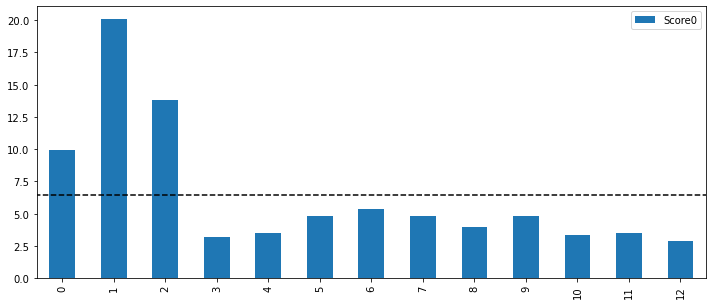

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
cv_results[['Score0']].plot.bar(ax=ax)
average_error = cv_results['Score0'].mean()
ax.plot([-1, cv_results.shape[0]], [average_error, average_error], "k--")

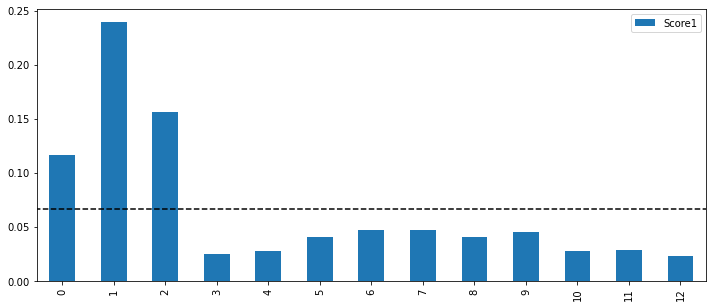

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))
cv_results[['Score1']].plot.bar(ax=ax)
average_error = cv_results['Score1'].mean()
ax.plot([-1, cv_results.shape[0]], [average_error, average_error], "k--")

In [13]:
var_max_lag = 50
var_selection_type = 'bic'

In [14]:
time_col = 'FLOW_DATE'
dependent_variable = 'RES_LEVEL_FT'
internal_regressors = ['INFLOW_CUSECS', 'OUTFLOW_CUECS']
initial = 3000
steps = 50
horizon = 90

dummy_data = dataset.copy()
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)
dummy_data = pd.get_dummies(dummy_data)

external_regressors = [column for column in dummy_data.columns if column not in [time_col] + [dependent_variable] + internal_regressors]

scoring_function = [mean_absolute_error, mean_absolute_percentage_error]

In [15]:
final_df = pd.DataFrame()

iterations = range(initial, dummy_data.shape[0], steps)

for x, i in enumerate(iterations):
    print("\n", round(100 * x / len(iterations), 2), "%\n")

    train_start = pd.to_datetime(dummy_data[time_col].min()).date()
    test_start = train_start + timedelta(i)
    test_end = test_start + timedelta(horizon-1)

    data_train, data_test = data_subset(dataset=dummy_data,
                                        time_col=time_col,
                                        dependent_variable=dependent_variable,
                                        internal_regressors=internal_regressors,
                                        train_start=str(train_start),
                                        test_start=str(test_start),
                                        test_end=str(test_end),
                                        external_regressors=external_regressors)

    var_model, lag_selection, optimal_lag = fit_var(data_train=data_train,
                                                       dependent_variable=dependent_variable,
                                                       internal_regressors=internal_regressors,
                                                       external_regressors=external_regressors,
                                                       maxlag=var_max_lag,
                                                       selection_type=var_selection_type)

    var_forecast = forecast_var(model=var_model,
                               data_train=data_train,
                               data_test=data_test,
                               dependent_variable=dependent_variable,
                               internal_regressors=internal_regressors,
                               optimal_lag=optimal_lag,
                               forecast_horizon=data_test.shape[0],
                               external_regressors=external_regressors)

    prophet_test = data_test.copy()

    for internal_regressor in internal_regressors:
        prophet_test.loc[:, internal_regressor] = var_forecast.loc[:, internal_regressor + '_FORECAST']
    
    i_reg = ['FLOW_DIFF']
    
    train_seed = data_train.iloc[0]['RES_LEVEL_FT']
    test_seed = data_train.iloc[-1]['RES_LEVEL_FT']
    
    data_train['RES_LEVEL_FT'] = data_train['RES_LEVEL_FT'].diff()
    data_train = data_train.dropna()
    
    data_train['FLOW_DIFF'] = data_train['INFLOW_CUSECS'] - data_train['OUTFLOW_CUECS']
    data_train = data_train.drop(columns = ['INFLOW_CUSECS', 'OUTFLOW_CUECS'])
    
    prophet_test['FLOW_DIFF'] = prophet_test['INFLOW_CUSECS'] - prophet_test['OUTFLOW_CUECS']
    prophet_test = prophet_test.drop(columns = ['INFLOW_CUSECS', 'OUTFLOW_CUECS'])
    
    prophet_model = fit_prophet(data_train=data_train,
                                dependent_variable=dependent_variable,
                                internal_regressors=i_reg,
                                external_regressors=external_regressors)

    prophet_forecast = forecast_prophet(model=prophet_model,
                                        data_test=prophet_test)
    
    prophet_forecast.iloc[0, -1] = prophet_forecast.iloc[0, -1] + test_seed
    prophet_forecast['yhat'] = prophet_forecast['yhat'].cumsum()

    eval_dict = {}
    for j, func in enumerate(scoring_function):
        eval_dict['Score' + str(j)] = [func(y_true = data_test[dependent_variable],
                                            y_pred = prophet_forecast['yhat'])]


    current_eval = pd.DataFrame(eval_dict)
    current_eval['Train_Start'] = train_start
    current_eval['Test_Start'] = test_start
    current_eval['Test_End'] = test_end

    if final_df.shape[0] == 0:
        final_df = current_eval
    else:
        final_df = pd.concat([final_df, current_eval], axis=0)

print("\n", 100, "%\n")

final_df.index = range(final_df.shape[0])


 0.0 %



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.93331
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8524.45   0.000188501       164.713           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8525.14   3.46546e-05       131.457      0.5523      0.5523      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8525.55   0.000217287       112.722           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     367       8525.65   3.72758e-05        83.686   4.182e-07       0.001      445  LS failed, Hessian reset 
     399       8525.67    6.8714e-05       85.3664           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8525.69   2.72981e-05    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.17235
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8688.72   0.000189206       120.694           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8689.58   0.000319002       178.356      0.9054      0.9054      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8689.97   6.13966e-05        59.066      0.3487      0.3487      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357          8690    5.9875e-06       76.0877   6.188e-08       0.001      446  LS failed, Hessian reset 
     393       8690.01   2.41902e-07       74.2568     0.06967           1      490   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

 15.38 %



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.95117
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        8851.7   0.000725526       229.458      0.4533      0.4533      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8852.53    0.00160619       355.182      0.7871      0.7871      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8852.91   0.000613647       212.676           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8853.13   0.000143885       87.5433           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8853.17   0.000103667       80.2523           1           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.51801
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8965.68   0.000304625       130.885      0.8157      0.8157      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8966.68    7.4393e-05       77.8075      0.8581      0.8581      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8967.04   5.04384e-05       91.1446      0.8721      0.8721      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8967.12   5.04476e-06       84.7547           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     449       8967.12   3.49843e-06       90.4794      0.2666           1      527   
Optimization terminated normally: 
  Convergence detected: relat

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.51815
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9133.13   0.000450354       154.062      0.7867      0.7867      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9133.98   0.000619736       224.306           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9134.86    0.00031019       66.3182           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9134.96   6.84754e-06       82.7574   9.151e-08       0.001      504  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     411       9134.96   4.08144e-07        69.631      0.2064           1      521   
Optimization terminated normally: 
  Con

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.53522
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9297.19   0.000369202       220.117      0.9085      0.9085      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9298.15    0.00328848       289.443           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9298.43   7.54274e-06       58.8314      0.3208           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9298.52   2.12633e-05       77.7987           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9298.55   4.59161e-05       131.866           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.51998
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        9464.9   0.000129546       122.766      0.6067      0.6067      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9465.54   9.95097e-05       152.146           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9466.01   0.000749323       114.481      0.3668           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        9466.1   3.45222e-05       78.1746           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9466.12   2.42957e-05       90.9169           1           1      578   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.52729
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9633.04    0.00184499       195.104      0.4858           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9634.07   0.000488861       126.643           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9634.22   0.000365018       95.3851           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        9634.5    0.00132602        94.853           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9634.58   3.09824e-05       96.6224           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.84573
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9801.64   0.000114996       177.207      0.3928      0.3928      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9803.08   0.000106382       129.606           1           1      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9803.39    8.9804e-06       86.5349       2.284      0.6126      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336        9803.4   1.67279e-05       80.2824   2.418e-07       0.001      425  LS failed, Hessian reset 
     377       9803.41   9.13584e-06       72.4605   9.534e-08       0.001      514  LS failed, Hessian reset 
     386       9803.41   4.75431e-07       55.9287      0.3756           1      526   
Optimization terminat

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.57591
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9970.35    0.00152229       344.644           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9971.81   0.000258584         120.6           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9972.12   5.73811e-05       97.1882           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     369       9972.18   6.27286e-05       103.311   6.433e-07       0.001      467  LS failed, Hessian reset 
     399       9972.19   9.33227e-06       91.9741      0.4157           1      501   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9972.21   0.000318372    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.67114
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10136.2    0.00080938       104.276           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10136.8   0.000804856       196.071      0.5781      0.5781      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10137.1   0.000358162       74.2229           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10137.2   0.000431426       83.7003           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10137.2   4.46777e-06       77.4567       1.294      0.1294      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.61362
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10294.2   0.000418528       139.226           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10295.5    0.00184642       116.885           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         10296   0.000768037       129.162           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10296.2   8.65795e-05       118.686      0.6122      0.6122      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10296.4   0.000449699       68.8815           1           1      582   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.61622
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10461.3   0.000336056       178.595           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10462.7    0.00707439       223.377           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10463.3   0.000167366       85.0591      0.3516      0.3516      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10463.6   5.26651e-05       99.1069           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10463.7   1.97164e-06       76.7215           1           1      567   
    Iter      log prob        ||dx||      ||grad||       alpha  

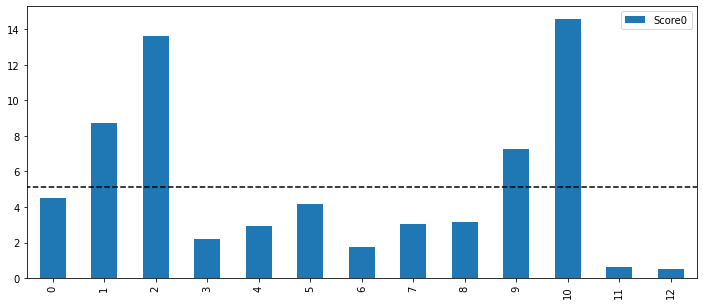

In [16]:
fig, ax = plt.subplots(figsize=(12, 5))
final_df[['Score0']].plot.bar(ax=ax)
average_error = final_df['Score0'].mean()
ax.plot([-1, final_df.shape[0]], [average_error, average_error], "k--")

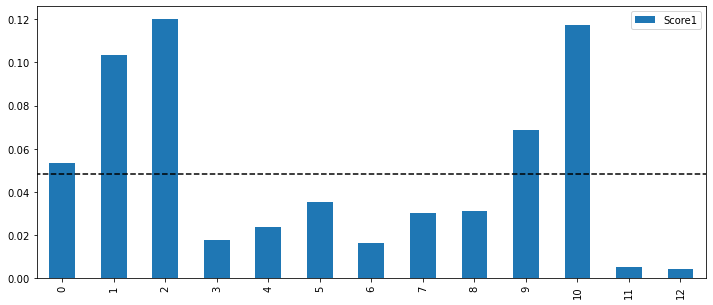

In [17]:
fig, ax = plt.subplots(figsize=(12, 5))
final_df[['Score1']].plot.bar(ax=ax)
average_error = final_df['Score1'].mean()
ax.plot([-1, final_df.shape[0]], [average_error, average_error], "k--")

In [18]:
time_col = 'FLOW_DATE'
dependent_variable = 'RES_LEVEL_FT'
internal_regressors = ['INFLOW_CUSECS', 'OUTFLOW_CUECS']
initial = 3000
steps = 50
horizon = 90

dummy_data = dataset.copy()
dummy_data['WEEK_NO'] = dummy_data['WEEK_NO'].astype(int).astype(str)
dummy_data['MONTH_NO'] = dummy_data['MONTH_NO'].astype(int).astype(str)
dummy_data = pd.get_dummies(dummy_data)

external_regressors = [column for column in dummy_data.columns if column not in [time_col] + [dependent_variable] + internal_regressors]

scoring_function = [mean_absolute_error, mean_absolute_percentage_error]

In [19]:
train_start = '2011-01-01'
test_start = '2020-09-18'
test_end = '2020-12-16'

data_train, data_test = data_subset(dataset=dummy_data,
                                    time_col=time_col,
                                    dependent_variable=dependent_variable,
                                    internal_regressors=internal_regressors,
                                    train_start=str(train_start),
                                    test_start=str(test_start),
                                    test_end=str(test_end),
                                    external_regressors=external_regressors)

var_model, lag_selection, optimal_lag = fit_var(data_train=data_train,
                                                   dependent_variable=dependent_variable,
                                                   internal_regressors=internal_regressors,
                                                   external_regressors=external_regressors,
                                                   maxlag=var_max_lag,
                                                   selection_type=var_selection_type)

var_forecast = forecast_var(model=var_model,
                           data_train=data_train,
                           data_test=data_test,
                           dependent_variable=dependent_variable,
                           internal_regressors=internal_regressors,
                           optimal_lag=optimal_lag,
                           forecast_horizon=data_test.shape[0],
                           external_regressors=external_regressors)

prophet_test = data_test.copy()

for internal_regressor in internal_regressors:
    prophet_test.loc[:, internal_regressor] = var_forecast.loc[:, internal_regressor + '_FORECAST']

i_reg = ['FLOW_DIFF']

train_seed = data_train.iloc[0]['RES_LEVEL_FT']
test_seed = data_train.iloc[-1]['RES_LEVEL_FT']

data_train['RES_LEVEL_FT'] = data_train['RES_LEVEL_FT'].diff()
data_train = data_train.dropna()

data_train['FLOW_DIFF'] = data_train['INFLOW_CUSECS'] - data_train['OUTFLOW_CUECS']
data_train = data_train.drop(columns = ['INFLOW_CUSECS', 'OUTFLOW_CUECS'])

prophet_test['FLOW_DIFF'] = prophet_test['INFLOW_CUSECS'] - prophet_test['OUTFLOW_CUECS']
prophet_test = prophet_test.drop(columns = ['INFLOW_CUSECS', 'OUTFLOW_CUECS'])

prophet_model = fit_prophet(data_train=data_train,
                            dependent_variable=dependent_variable,
                            internal_regressors=i_reg,
                            external_regressors=external_regressors)

prophet_forecast = forecast_prophet(model=prophet_model,
                                    data_test=prophet_test)

prophet_forecast.iloc[0, -1] = prophet_forecast.iloc[0, -1] + test_seed
prophet_forecast['yhat'] = prophet_forecast['yhat'].cumsum()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.61722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10287.5    0.00160238       156.804           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10288.9    0.00144234       265.263           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10289.4   6.04919e-05       85.3584      0.8221      0.8221      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10289.5   4.15167e-05       95.5838           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       10289.6   8.76826e-05       77.7368      0.9516      0.9516      565   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [20]:
prophet_fitted = forecast_prophet(model=prophet_model,
                                  data_test=data_train)
prophet_fitted.iloc[0, -1] = prophet_fitted.iloc[0, -1] + train_seed
prophet_fitted['yhat'] = prophet_fitted['yhat'].cumsum()

In [21]:
prophet_forecast['y_actual'] = data_test['RES_LEVEL_FT'].values

<AxesSubplot:title={'center':'RES_WATER_LEVEL_FORECAST'}, xlabel='ds'>

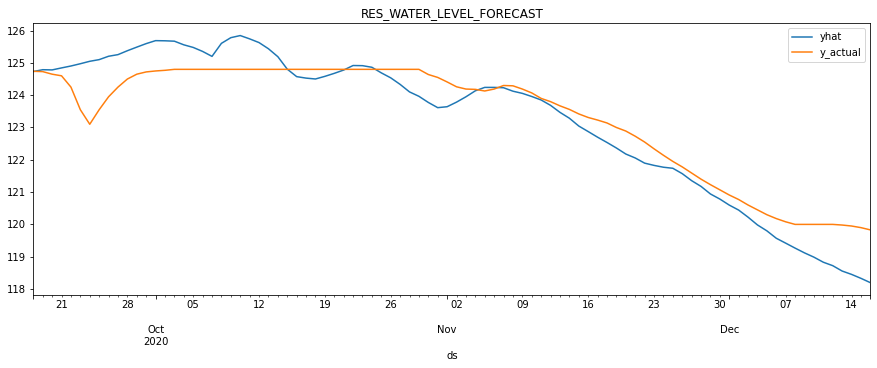

In [22]:
prophet_forecast.set_index('ds')[['yhat', 'y_actual']].plot(figsize=(15, 5), title='RES_WATER_LEVEL_FORECAST')

In [23]:
data_train, data_test = data_subset(dataset=dummy_data,
                                    time_col=time_col,
                                    dependent_variable=dependent_variable,
                                    internal_regressors=internal_regressors,
                                    train_start=str(train_start),
                                    test_start=str(test_start),
                                    test_end=str(test_end),
                                    external_regressors=external_regressors)

In [24]:
prophet_fitted['y_actual'] = data_train.iloc[1:, :]['RES_LEVEL_FT'].values

<AxesSubplot:title={'center':'INFLOW'}, xlabel='FLOW_DATE'>

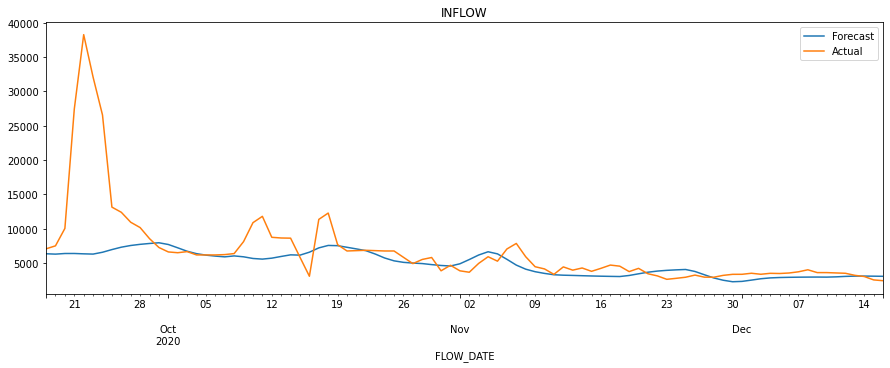

In [25]:
pd.DataFrame({
    'Forecast': var_forecast['INFLOW_CUSECS_FORECAST'],
    'Actual': data_test['INFLOW_CUSECS']}).plot(figsize=(15, 5), title='INFLOW')

<AxesSubplot:title={'center':'OUTFLOW'}, xlabel='FLOW_DATE'>

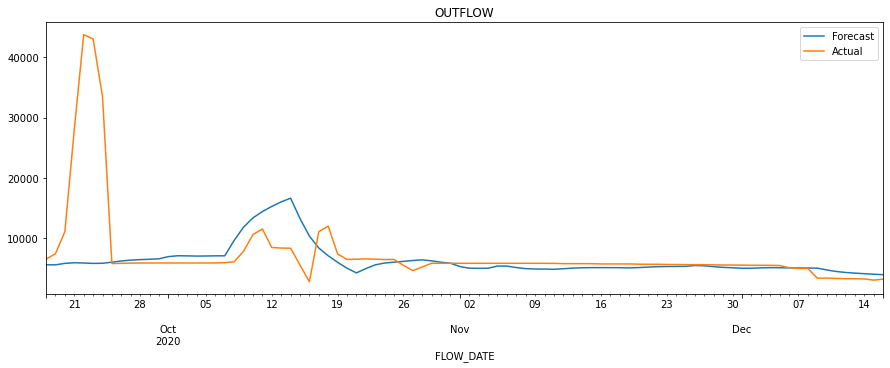

In [26]:
pd.DataFrame({
    'Forecast': var_forecast['OUTFLOW_CUECS_FORECAST'],
    'Actual': data_test['OUTFLOW_CUECS']}).plot(figsize=(15, 5), title='OUTFLOW')

<AxesSubplot:title={'center':'RES_LEVEL_FT_FITTED'}, xlabel='ds'>

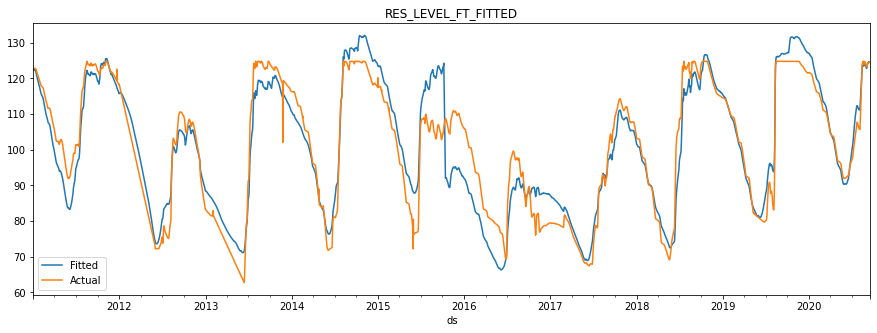

In [27]:
pd.DataFrame({
    'Fitted': prophet_fitted.set_index('ds')['yhat'],
    'Actual': prophet_fitted.set_index('ds')['y_actual']}).plot(figsize=(15, 5), title='RES_LEVEL_FT_FITTED')

<AxesSubplot:title={'center':'Residuals'}, xlabel='DS'>

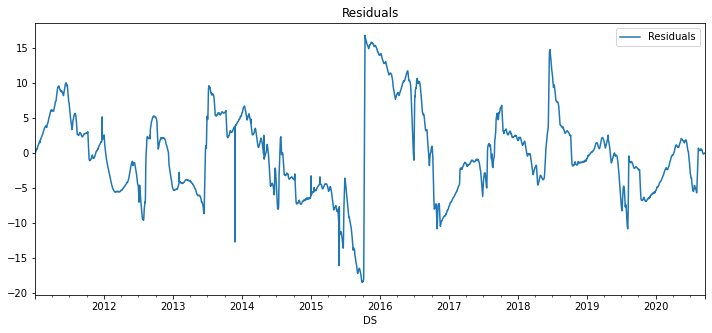

In [28]:
residuals = pd.DataFrame({
    'Residuals': prophet_fitted['y_actual'] - prophet_fitted['yhat'],
    'DS': prophet_fitted['ds']}).set_index('DS')

residuals.plot(title='Residuals', figsize=(12, 5))

<AxesSubplot:ylabel='Frequency'>

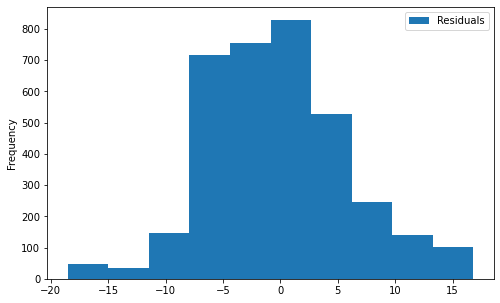

In [29]:
residuals.plot.hist(figsize=(8, 5))

In [30]:
from statsmodels.tsa.stattools import acf

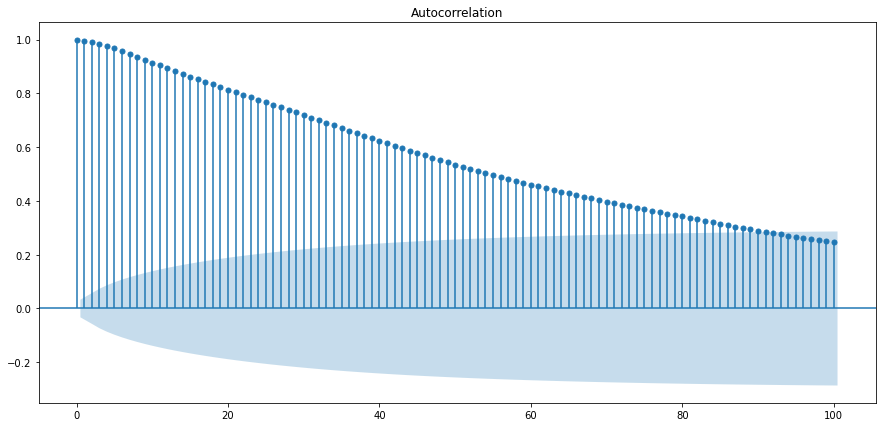

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(15, 7))
plot_acf(residuals['Residuals'], lags=100, ax=ax)
plt.show()

In [32]:
eval_dict

{'Score0': [0.4956957015895211], 'Score1': [0.0041055405025019745]}

In [44]:
prophet_forecast.groupby('Month').agg({'yhat': 'mean'})

,yhat
Month,
9,125.084434
10,124.968913
11,122.848961
12,119.281031
